# Importing libs

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# Dataset preparation (just for Unet testing)

In [2]:
class Dataset_test(Dataset):
    def __init__(self,img_dir,transform = None):
        self.img_dir = img_dir
        self.transform = transform
        self.size = (572,572)
    
    def __len__(self):
        return len(os.listdir(self.img_dir))
    
    def __getitem__(self,idx):
        images_list = os.listdir(self.img_dir)
        
        image = cv2.imread(self.img_dir+images_list[idx])
        
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
        image = cv2.resize(image,self.size)
        
        if self.transform:
            image = self.transform(image)
        return image
    

In [3]:
data = Dataset_test("Data/Dataset2/manual_contours_ch4/images/",transforms.ToTensor())

In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(data, batch_size=1, shuffle=True)

train_features= next(iter(train_dataloader))


# Model definition

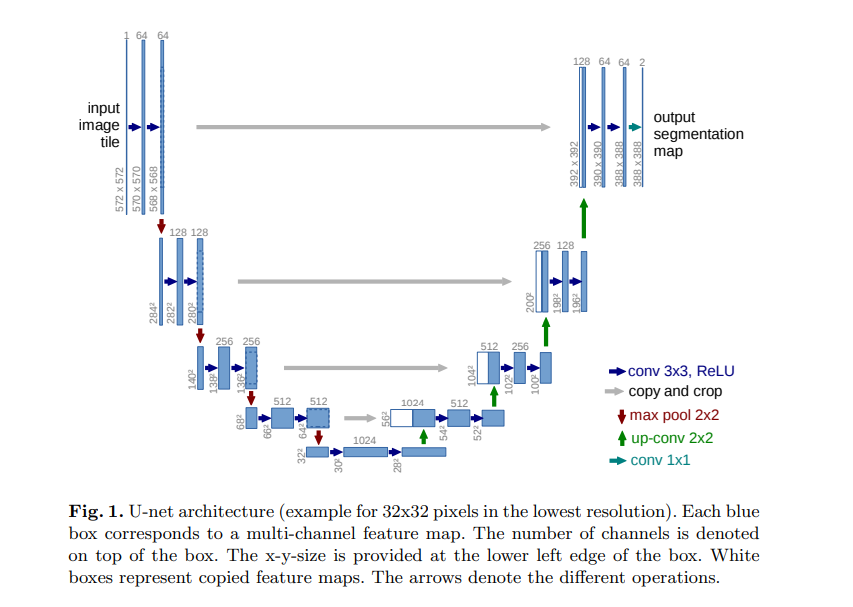

## Contracting path

In [5]:
class down_conv(nn.Module):
    
    def __init__(self,in_channels,out_channels):
        super(down_conv,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,3,1)
        self.conv2 = nn.Conv2d(out_channels,out_channels,3,1)
        
        
    def forward(self,x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        return x

In [6]:
class Encoder(nn.Module):
    
    def __init__(self):
        super(Encoder,self).__init__()
        
        self.bloc1 = down_conv(1,64)
        self.bloc2 = down_conv(64,128)
        self.bloc3 = down_conv(128,256)
        self.bloc4 = down_conv(256,512)
        self.bloc5 = down_conv(512,1024)
        self.pooling = nn.MaxPool2d(2,2)
        
    def forward(self,x):
        
        features = []
        x = self.bloc1.forward(x)
        
        features.append(x)
        
        x = self.pooling(x)
        x = self.bloc2.forward(x)
        
        features.append(x)
        
        x = self.pooling(x)
        x = self.bloc3.forward(x)
        
        features.append(x)
        
        x = self.pooling(x)
        x = self.bloc4.forward(x)
        
        features.append(x)
        
        x = self.pooling(x)
        x = self.bloc5.forward(x)
        
        features.append(x)
        
        return features

In [7]:
model = Encoder()

y = model.forward(train_features)

In [8]:
for i in y:
    print(i.shape)

torch.Size([1, 64, 568, 568])
torch.Size([1, 128, 280, 280])
torch.Size([1, 256, 136, 136])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 28, 28])


In [ ]:
x = y[-1]

x = x[0]

for i in x[:10] : 
    plt.imshow(i.detach().numpy())
    plt.show()

## Expanding path

In [10]:
class up_conv(nn.Module):
    
    def __init__(self,idx,in_channels,out_channels):
        super(up_conv,self).__init__()
        
        self.id = idx
        self.up_conv = nn.ConvTranspose2d(in_channels,out_channels,3,padding=1)
        self.upsample = nn.Upsample(scale_factor = 2, mode = 'bicubic',align_corners = True)
        self.conv = nn.Conv2d(in_channels,out_channels,3)
        self.conv2 = nn.Conv2d(out_channels,out_channels,3)
        
    def forward(self,x,features):
                
        x = self.upsample(x)
        x = self.up_conv(x)
        x = self.copy_crop(features,x,self.id)
        x = self.conv(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        return x
    
    def copy_crop(self,features,X,idx):
        
        _,_,height,width = X.shape
        center_crop = transforms.CenterCrop([height,width])
        cropped_feature = center_crop(features[-idx-1])
        
        X = torch.cat((cropped_feature,X),1)
        return X

       

In [11]:
class Decoder(nn.Module):
    
    def __init__(self):
        
        super(Decoder,self).__init__()
        
        self.conv_up1 = up_conv(1,1024,512)
        self.conv_up2 = up_conv(2,512,256)
        self.conv_up3 = up_conv(3,256,128)
        self.conv_up4 = up_conv(4,128,64)
        self.conv_final = nn.Conv2d(64,2,1)
    
    def forward(self,x,features):
        
        x = self.conv_up1.forward(x,features)
        x = self.conv_up2.forward(x,features)
        x = self.conv_up3.forward(x,features)
        x = self.conv_up4.forward(x,features)
        
        x = self.conv_final(x)
        
        return x

In [12]:
decoder = Decoder()

x = y[-1]
x.shape
z = decoder.forward(x,y)
z.shape

torch.Size([1, 2, 388, 388])

## Unet architecture

In [13]:
class Unet(nn.Module):
    
    def __init__(self):
        
        super(Unet,self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self,x):
        
        features = self.encoder.forward(x)
        x = features[-1]
        y = self.decoder.forward(x,features)
        
        return y

In [14]:
model = Unet()
y = model.forward(train_features)

# Training 